In [21]:
import mne
#Using locs to read montage
montage_NE = mne.channels.read_montage(kind='Enobio32',ch_names = [ 'Cz', 'Pz', 'C4', 'Fp2', 'C3', 'Fp1', 'CP2', 'CP1'],
                                       path=r'F:\software\1NE_NIC2\1channelL')
raw = mne.io.read_raw_eeglab(input_fname=r'F:\software\1EEGLAB\set_raw_data\firstExp_noEvent.set',montage=montage_NE, preload=True)

Reading F:\software\1EEGLAB\set_raw_data\firstExp_noEvent.fdt
Reading 0 ... 105893  =      0.000 ...   211.786 secs...


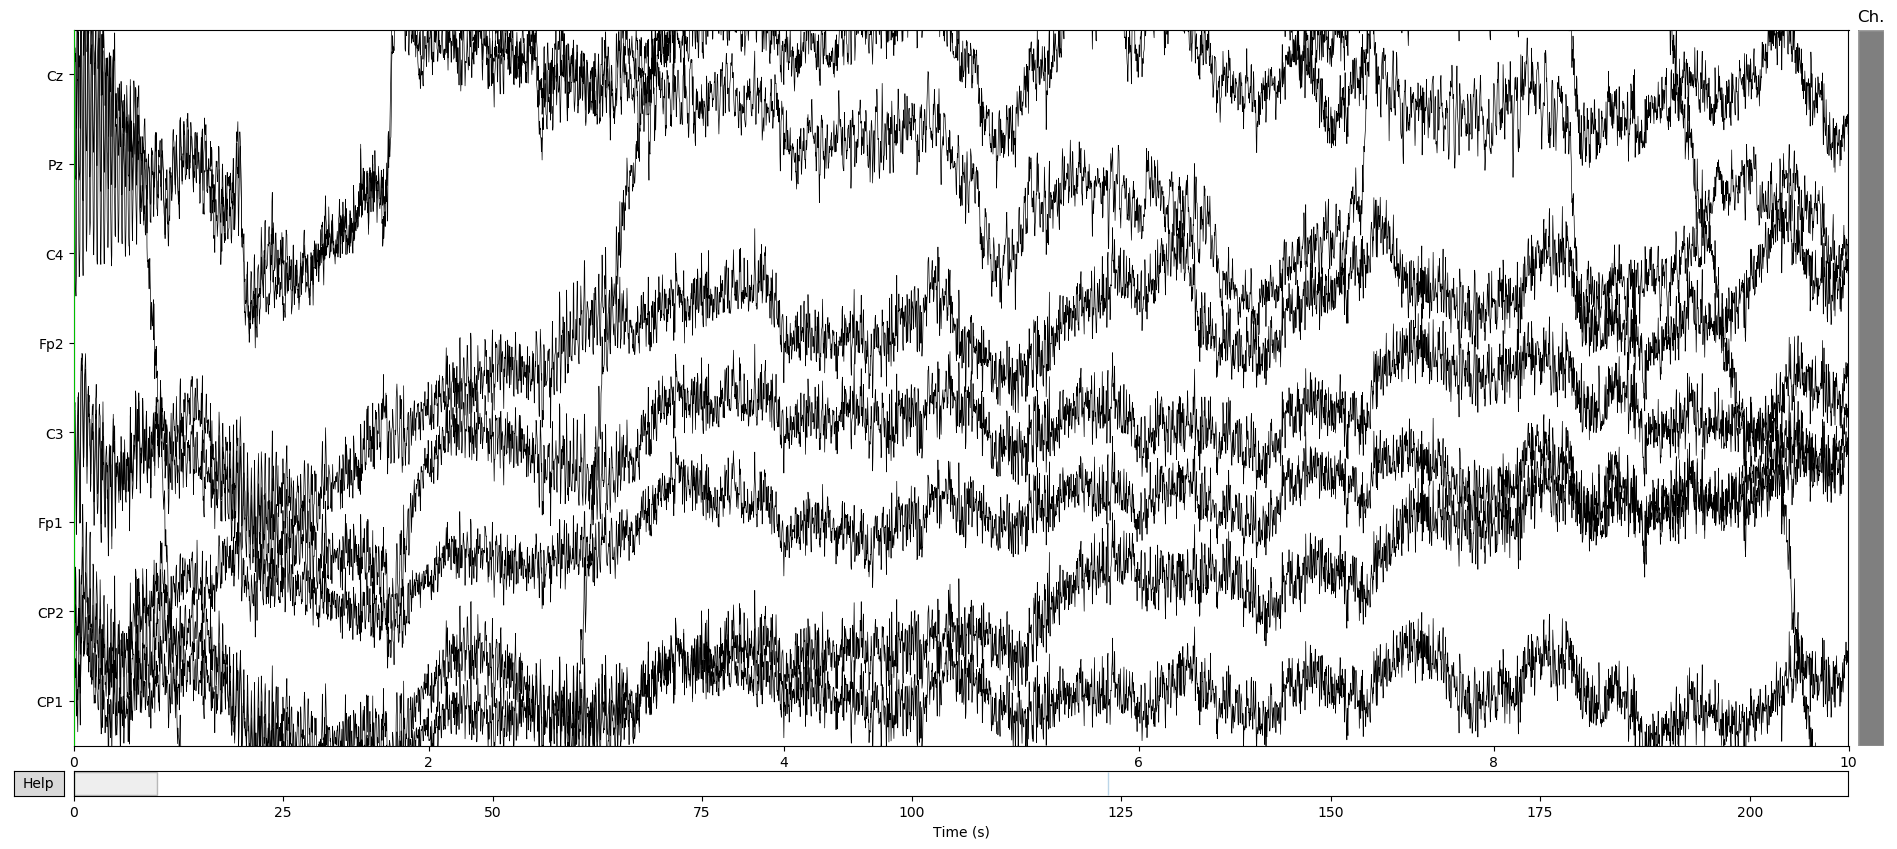

In [22]:
raw.plot()

In [ ]:
#### 		Read from Enobio EEG Data		####

 # The stream_name must be the same as in NIC/COREGUI.
 # The streams vector gathers all the streams available.
 # If the NIC stream is inside this vector, the element index is saved in the index variable.
 # The stream inlet attempts to connect to the NIC stream.
 # If the stream has not been found within the available streams, the scripts raises an error and stops.
 # If not, the script starts retrieving data from the NIC stream.

from pylsl import StreamInlet, resolve_stream

stream_name = 'NIC'
streams = resolve_stream('type', 'EEG')

try:
	for i in range (len(streams)):

		if (streams[i].name() == stream_name):
			index = i
			print ("NIC stream available")

	print ("Connecting to NIC stream... \n")
	inlet = StreamInlet(streams[index])   

except NameError:
	print ("Error: NIC stream not available\n\n\n")

while True:
    sample, timestamp = inlet.pull_sample()
    print("Timestamp: \t %0.5f\n Sample: \n %s\n\n" %(timestamp,   sample))

# Reading ENOBIO with NEPy

In [29]:
from nepy import readers
# easyReader(filepath = r'C:\Users\aegea\Documents\NIC\20190912114520_Patient01_rawfilerecording.easy')
# dir(readers.__loader__)
from nepy.readers.easyReader import easyReader
easy_readers()

Failed: Fixture "easy_readers" called directly. Fixtures are not meant to be called directly,
but are created automatically when test functions request them as parameters.
See https://docs.pytest.org/en/latest/fixture.html for more information about fixtures, and
https://docs.pytest.org/en/latest/deprecations.html#calling-fixtures-directly about how to update your code.

In [24]:
"""
Test to the easyReader class of nepy.
The test imports the ground truth to perform the asserts from test_data.py and asserts all the necessary data to create
a capsule and perform a Frida test.
In case you want to perform the test with different data:
    1. Add your files in nepy/tests/testfiles folder
    2. Modify the ground truth in test_data.py (See documentation)
In case you have modified the easyReader class, then you might need to modify these test functions too.

2019 Neuroelectrics Barcelona
@author: R Sanchez (roser.sanchez@neuroelectrics.com)
"""

import pytest
import os
import datetime
import numpy as np

from nepy.tests.test_data import easyTestData
from nepy.readers.easyReader import easyReader
from nepy.tests.test_data import testpath


@pytest.fixture(scope='module')
def easy_readers():
    """ Loading all the .easy files of the testfiles directory and then initializing a reader for each of them.
    :return: a list of the readers for all files.
    """
    if os.path.isdir(testpath) is False:
        pytest.exit('The the -testfiles- folder path of your computer does not match with the one written '
                    'in test_data.py (testpath) ')
    rdrs = {}  # Dictionary containing a reader per test file.
    for file in easyTestData:
        filepath = os.path.join(testpath, easyTestData[file]['filename']+'.easy')
        try:
            rdrs[file] = easyReader(filepath)
        except FileNotFoundError:
            print('\033[1;31;0m There is a file missing: ', easyTestData[file]['filename']+'.easy')
            print('\033[1;31;0mMake sure that the file exists in the folder.')
            pytest.exit()
    return rdrs


def test_inits(easy_readers):
    """ In this test we assert if all the information regarding file names is recorded correctly in the easyReader
    class """
    assert len(easyTestData) == len(easy_readers)  # Are all the files loaded correctly?
    for file in easyTestData:
        assert easy_readers[file].filepath.endswith(easyTestData[file]['filename']+'.easy')
        assert easyTestData[file]['filename'] == easy_readers[file].basename
        assert ('easy' == easy_readers[file].extension) or ('easy.gz' == easy_readers[file].extension)
        assert 'anonymous' == easy_readers[file].author
        filepath = os.path.join(testpath, easyTestData[file]['filename'])
        assert filepath == easy_readers[file].filenameroot
        assert filepath+'.info' == easy_readers[file].infofilepath
        assert 500. == easy_readers[file].fs


def test_getinfo(easy_readers):
    """ Test if the reader reads correctly the channel information, even if we don't have .info file """
    for file in easyTestData:
        assert len(easyTestData[file]['chanlist']) == easy_readers[file].num_channels
        assert easyTestData[file]['chanlist'] == easy_readers[file].electrodes


def test_get10data(easy_readers):
    """ Test if the EEG, accelerometer, markers and dates are loaded correctly """
    for file in easyTestData:
        # Load data from easyTestData database
        numchan = len(easyTestData[file]['chanlist'])
        first = easyTestData[file]['first_easy_row']
        numcols = len(easyTestData[file]['first_easy_row'])

        # Get the information we want to assert
        first_eegdata = np.float32(np.array(first[:numchan])/1000.)
        first_accdata = np.array(first[numchan:numchan + 3])
        first_markdata = np.array(first[numchan + 3])
        first_dateraw = first[-1]
        first_date = datetime.datetime.fromtimestamp(first_dateraw / 1000).strftime("%Y-%m-%d %H:%M:%S")

        assert len(first_eegdata) == len(easy_readers[file].np_eeg[0, :])
        assert easyTestData[file]['num_samples'] == len(easy_readers[file].np_eeg)
        assert np.array_equal(first_eegdata, easy_readers[file].np_eeg[0, :])
        if (numcols == 13) or (numcols == 25) or (numcols == 37):
            assert easy_readers[file].acc_data
        assert np.array_equal(first_accdata, easy_readers[file].np_acc[0, :])
        assert easyTestData[file]['num_samples'] == len(easy_readers[file].np_acc)
        assert np.array_equal(first_markdata, easy_readers[file].np_markers[0])
        assert easyTestData[file]['num_samples'] == len(easy_readers[file].np_markers)
        assert first_date == easy_readers[file].eegstartdate
        assert easyTestData[file]['num_samples'] == len(easy_readers[file].np_time)

        # For more exhaustive testing we need to have more rows to test in the fields of the test data.
        if 'more_rows' in easyTestData[file]:
            for ind in range(len(easyTestData[file]['more_rows'])):
                # Load the info for each of the lines
                row = easyTestData[file]['more_rows'][ind]
                row_ind = row[0]-1  # We subtract 1 since Notepad starts the indexing in 1.
                eegdata = np.float32(np.array(row[1:numchan+1]) / 1000.)
                accdata = np.array(row[numchan+1:numchan + 4])
                markdata = np.array(row[numchan + 4])

                # Perform the assertions
                assert np.array_equal(eegdata, easy_readers[file].np_eeg[row_ind, :])
                if (numcols == 13) or (numcols == 25) or (numcols == 37):
                    assert easy_readers[file].acc_data
                assert np.array_equal(accdata, easy_readers[file].np_acc[row_ind, :])
                assert np.array_equal(markdata, easy_readers[file].np_markers[row_ind])





In [ ]:
"""
This is easyReader, a class to read “.easy” files and obtain their data.
It is an object that contains data from easy and info files (the latter if available),
and provides methods to obtain this information.

2018 Neuroelectrics Corporation

Created on Tue Feb 14 2018 modified on Mon Sept 24 2018 (roser)
@author: giulio (NE)
"""

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import os
import time
import datetime
import pandas as pd
 

class easyReader(object):
    """
        Example of use:

            >>> c = easyReader("easydata/20180213122712_Patient01.easy")

        You must provide the relative or absolute path to the data file.
        The EEG data for processing is kept in .np_eeg and is a numpy array,
        and its shape is (num eeg samples,num channels), e.g., 

            >>> c.np_eeg.shape = (15000, 32)

        The accelerometer data for processing is kept in .np_acc and is a numpy array,
        and its shape is (num acc samples,num acc channels), e.g., 

            >>> c.np_acc.shape = (3000, 3)

        The markers are kept in .np_markers and is a numpy array,
        and its shape is (numsamples), e.g.,

            >>> c.np_markers.shape = 15000
        """
  
    def __init__(self, filepath, author="anonymous", verbose=True):

        print("\033[1mInitializing in file path: \033[0m ", filepath)

        # Let us find the extension, or exit if not recognized:
        if filepath.endswith(".easy.gz"):
            filenameroot = filepath[:-8]
            basename = os.path.basename(filepath)[:-8]
            extension = "easy.gz"
            print("\033[1mProcessing: \033[0m", basename)
            print("\033[1mFilenameroot: \033[0m", filenameroot)
            print("\033[1mExtension: \033[0m", extension)
            
        elif filepath.endswith(".easy"):
            extension = "easy"
            filenameroot = filepath[:-5]
            basename = os.path.basename(filepath)[:-5]
            print("\033[1mProcessing: \033[0m", basename)
            print("\033[1mFilenameroot: \033[0m", filenameroot)
            print("\033[1mExtension: \033[0m", extension)
        else: 
            print("\033[91m ERROR @capsule __init__: proposed file has wrong extension. Exiting. \033[0m")
            return
            
        print(" ")

        self.capsuledate = time.strftime("%Y-%m-%d %H:%M")
        self.log = ["capsule created: " + self.capsuledate]
        self.filepath = filepath
        self.basename = basename
        self.extension = extension
        self.author = author
        self.filenameroot = filenameroot
        self.infofilepath = filenameroot + ".info"
        self.fs = 500.
        # Initialize all empty attributes:
        self.acc_data = False
        self.electrodes = []
        self.num_channels = None
        self.eegstartdate = None
        self.np_time = []
        self.np_eeg = []
        self.np_stim = []
        self.np_acc = []
        self.np_markers = []

        # Try to read info file
        self.info_flag = self.__get_info(verbose=verbose)
        # then read data part, easy file
        self.__get_l0_data(verbose=verbose)

    def listAttributes(self):
        """Convenience function, prints list of attributes."""
        for attr in sorted(self.__dict__.keys()):
            print("-", attr, ":\n", self.__dict__[attr], "\n\n")
        print("_______________________________________________________________")
    
    def __get_info(self, verbose=True):
        """ 
        Read .info file, basically to grab electrode names.
        """
        if verbose:
            print("_______________________________________________________________")
            print("\033[1mReading info file ...\033[0m")
        electrodes = []
        try:
            data_file = open(self.infofilepath, 'r')
            for line in data_file.readlines():
                if verbose:
                    print(line[:-1])
                if "Channel " in line[:-1]:
                    electrodes.append(line.split()[-1])
                if "Accelerometer data: " in line[:-1]:
                    self.acc_data = True
                    break
            self.electrodes = electrodes
            flag = 0
            if verbose:
                print(".info file found and read.\n")
        except OSError:
            print("\033[93m Warning! .info file not found! Using standard values... \033[0m")
            print("Reading ", self.filepath, "to get numchannels....\n")
            df = pd.read_csv(self.filepath, delim_whitespace=True, nrows=5)

            cols = df.iloc[:, :].shape[1]
            if (cols == 13) or (cols == 25) or (cols == 37):
                numchannels = df.iloc[:, :].shape[1] - 5
                self.acc_data = True
            elif (cols == 10) or (cols == 22) or (cols == 34):
                numchannels = df.iloc[:, :].shape[1] - 2
            else:
                print('There is an error with the .easy format.')
                print('Number of columns mismatch with the expected for any of the devices')
                print('Exiting...')
                return
            print("numchannels .......", numchannels)
            self.electrodes = ["Ch"+str(x) for x in range(1, 1+numchannels)]
            flag = 1
        self.num_channels = len(self.electrodes) 
            
        return flag

    def __get_l0_data(self, verbose=True):
        """
        Method to grab easy data and set to uV. Data is stored in numpy arrays frame
        """
        if verbose:
            print("_______________________________________________________________")
            print("\033[1mReading:", self.basename, '.', self.extension, '\n \033[0m')
        df = pd.read_csv(self.filepath, delim_whitespace=True, header=None)
        cols = df.iloc[:, :].shape[1]
        if (cols == 13) or (cols == 25) or (cols == 37):
            num_channels = df.iloc[:, :].shape[1] - 5
            self.acc_data = True
        elif (cols == 10) or (cols == 22) or (cols == 34):
            num_channels = df.iloc[:, :].shape[1] - 2
        else:
            print('There is an error with the .easy format.')
            print('Number of columns mismatch with the expected for any of the devices')
            print('Exiting...')
            return

        if num_channels != self.num_channels:
            print("numchannels", num_channels)
            print("self.num_channels", self.num_channels)
            print("\033[93m Something is wrong with numchannels in infofile...\033[0m")
        
        # grab first entry of last dataframe column (unix timestamp in ms)
        timestamp = df[df.columns[-1]][0] 
        value = datetime.datetime.fromtimestamp(timestamp/1000)
        eegstartdate = value.strftime('%Y-%m-%d %H:%M:%S')

        # name dataframe columes using electrodes, etc
        if self.acc_data:
            df.columns = self.electrodes + ['ax', 'ay', 'az'] + ['markers', 'unix_time']
        else:
            df.columns = self.electrodes + ['markers', 'unix_time']
        
        df.iloc[:, 0:num_channels] = df.iloc[:, 0:num_channels]/1000  # now in uV

        if verbose:
            print("Number of channels detected:", num_channels)
            print("First sample recorded :", eegstartdate, "\n")
            print(" L0 raw data data in uV")
            print(df.describe())
        
        # assign attributes
        self.eegstartdate = eegstartdate
        self.np_eeg = np.array(df, dtype="float32")[:, 0:num_channels]
        # create a time column in seconds from beginning of file
        df['t'] = (df['unix_time']-df['unix_time'][0])/1000.  # go to seconds
        self.np_time = np.array(df['t'], dtype="float32")
        self.log.append("Got raw L0_data on " + time.strftime("%Y-%m-%d %H:%M"))
        self.np_acc = np.array(df, dtype="float32")[:, num_channels:num_channels+3]
        if self.acc_data:
            self.np_markers = np.array(df, dtype="float32")[:, num_channels+3]
        else:
            self.np_markers = np.array(df, dtype="float32")[:, num_channels]
        
        return


In [6]:
from nepy.readers.easyReader import easyReader
c = easyReader("C:/users/aegea/Documents/NIC/20190912114520_Patient01_rawfilerecording.easy")

Initializing in file path:   C:/users/aegea/Documents/NIC/20190912114520_Patient01_rawfilerecording.easy
Processing:  20190912114520_Patient01_rawfilerecording
Filenameroot:  C:/users/aegea/Documents/NIC/20190912114520_Patient01_rawfilerecording
Extension:  easy
 
_______________________________________________________________
Reading info file ...
Step Details
Info Version: 1.2
Step name: raw file recording
StartDate (firstEEGtimestamp): 1568259919999
Device class: STARSTIM (EEG only mode)
Communication type: WiFi
Device ID: NE-Wifi(00:07:80:0D:72:27)
Software's version: NIC v2.0.9
Firmware's version: 4012
Operative system: Windows
SDCard Filename: NONE
Additional channel: NONE

EEG Settings
Total number of channels: 8
Number of EEG channels: 2
Number of records of EEG: 17354
EEG sampling rate: 500 Samples/second
EEG recording configured duration (s): 1800
Number of packets lost: 0
Line filter status: 50 Hz
FIR filter status: OFF
EOG correction filter status: OFF
Reference filter stat

In [19]:
c.np_eeg[:,4]


array([-400000.06, -400000.06, -400000.06, ..., -400000.06, -400000.06,
       -400000.06], dtype=float32)

In [25]:
"""
This file contains all the ground truth to perform the nepy basic tests.
It is linked to the folder testdata.

Please copy and paste the path of the test data in the testdata variable below.
The original test data is located in this path:

    '//antares.starlab.es//Phact//6 - Neuroelectrics//6.3 - Development & Production//NEPy//
    1- Project//1.4- WPs Working Area//DATA//testfiles'

Every field in the easyTestData and nedfTestdata is a file in the folder.
If you want to perform the nepy tests with other data please make sure that you store the necessary information in
this file following the format:

- each FIELD in the dictionaries is the ID of the file. In this case we have Enobio and StarStim files with different
number of channels and with/without .info file data. We have decided to name the files's ID with 'E' if it an Enobio
file and 'SS' if it StarStim. The number behind corresponds to the number of channels and if there's no info file it
says _noinfo. But be free to follow any other convention.

- Each of the files is at the same time another dictionary, so we have nested dicitonaries to define the ground data
to test. Each of this subdictionaries (corresponding to a file in the testdata folder) contains at the same time
different fields to fill if you change the testing files:

    ['filename']: name of the file, as it is, without the extension. Click on the file name or press F2 and you get it.

    ['chanlist']: the worse field to fill if you want to test a 32 channel device. Just copy the channel list in the
                    order that appears in the info file. IF you don't have the info file then it easy. There's a
                    function defined at the beginning of this file called 'elist_generator', you just need to call it,
                    the only argument of the function is the number of channels of the device. If you have a .nedf file
                    without .info file then you can't perform the test. Sorry. We can try to fix it in the future.

    ['first_easy_row']: this field is really important regarding the .nedf files. To test a .nedf file you need to have
                        the corresponding .easy file so you can copy the first row information. Just copy and paste
                        the first row of the .easy file as an array. Recommendation to not make if by hand:
                        open the easy file in Notepad++, copy the first row in a new Notepad++ text file. Then, find
                        and replace all the tabs '\t' by a coma and space ', '. Then you have it!
    ['more_rows']: optional field for a more exhaurstive testing. The rows are in the same format as the
                   'first_easy´_row' field, but there's an extra index at the beginning that specifies the row index.
                   If you edit it with Notepad++ it is easy to see the index in the left. (In the code we already take
                   into account that the first element of Notebook is not 0, as it is for Python)
                   It is important that it is a two dimensional array, even though you just input one extra row.

    ['num_samples']: to find the number of samples you also need the .easy file. Find how many rows the .easy file has
                    and copy that number to this field.

IMPORTANT NOTES:
    - to perform tests of .easy files you don't need the .info file
    - to perform tests of the .nedf file you need the respective .easy and .info file to can access to its data.
    - to perform a capsule test you need AT LEAST one .easy and one .nedf file in the folder.
    - it is really important to do the frida test that there is a file called fake_easy.easy in the testfiles folder.
    This .easy file is made out of this code:

            f = open('fake_easy.easy', 'w+')
            for i in range(500*60):
                f.write("{0}\t{0}\t{0}\t{0}\t{0}\t{0}\t{0}\t{0}\t1\t1\t1\t2\t1500000000000\n".format(i))
            f.close()


2019 Neuroelectrics Barcelona
@author: R Sanchez (roser.sanchez@neuroelectrics.com)

"""

# Copy and paste the directory of your compute of the testfiles.
testpath = '//antares.starlab.es//Phact//6 - Neuroelectrics//6.3 - Development & Production//NEPy//1- Project//' \
           '1.4- WPs Working Area//DATA//testfiles'


def elist_generator(n):
    """
    Generates an electrode list for the files that doesn't have .info file.
    Format: [Ch1, Ch2, Ch3, ...]
    """
    elist = []
    for n in range(1, n + 1):
        elist.append('Ch{0}'.format(n))
    return elist


# This is a global class with all the information regarding the test files.
easyTestData = {
    'E8': {
        'filename': '20181214090159_testboard_E8',
        'chanlist': ['F6', 'F4', 'F2', 'Fz', 'F1', 'F3', 'F5', 'Cz'],
        'first_easy_row': [311660, -598239, 223827, -279712, -266408, -31280, -512743, 195360, 0, 0, 0, 0,
                           1544774518507],
        'more_rows': [[321, 321626, -593519, 226497, -278329, -264215, -26512, -511217, 195646, 29, 186, 9443, 0,
                       1544774519607],
                      [216, 316095, -595665, 226211, -279426, -266933, -31280, -514078, 191926, -29, 225, 9326, 0,
                       1544774519397]],
        'num_samples': 90000
    },
    'E8_noinfo': {
        'filename': '20181214090159_testboard_E8_noinfo',
        'chanlist': elist_generator(8),
        'first_easy_row': [311660, -598239, 223827, -279712, -266408, -31280, -512743, 195360, 0, 0, 0, 0,
                           1544774518507],
        'more_rows': [[321, 321626, -593519, 226497, -278329, -264215, -26512, -511217, 195646, 29, 186, 9443, 0,
                       1544774519607]],
        'num_samples': 90000
    },
    'E20': {
        'filename': '20181214093909_testboard_E20',
        'chanlist': ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3',
                     'Fp1', 'T7', 'F7', 'EXT'],
        'first_easy_row': [139808, -589799, -81920, -68140, -144815, -8487, -210952, 371503, 344133, -368595, -58746,
                           -8153, -103759, 27704, -190210, 22792, 77438, -118064, -296402, -118446, 147, 0, 9326, 0,
                           1544776748908],
        'num_samples': 90000
    },
    'E20_noinfo': {
        'filename': '20181214093909_testboard_E20_noinfo',
        'chanlist': elist_generator(20),
        'first_easy_row': [139808, -589799, -81920, -68140, -144815, -8487, -210952, 371503, 344133, -368595, -58746,
                           -8153, -103759, 27704, -190210, 22792, 77438, -118064, -296402, -118446, 147, 0, 9326, 0,
                           1544776748908],
        'num_samples': 90000
    },
    'E32': {
        'filename': '20181214100347_testboard_E32',
        'chanlist': ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3',
                     'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1',
                     'FC5', 'AF3', 'PO3'],
        'first_easy_row': [458145, -81157, -131940, -96845, -172805, -117349, 54502, 55694, -762319, 344038, -168275,
                           139856, 27990, -379085, 92554, -480032, -104188, -278282, 95748, -136184, -314331, 335121,
                           -138711, 293064, -7152, -364637, 372219, -536203, 103998, -452899, -6723, -732517, 0, 0, 0,
                           0, 1544778225268],
        'num_samples': 90000
    },
    'E32_noinfo': {
        'filename': '20181214100347_testboard_E32_noinfo',
        'chanlist': elist_generator(32),
        'first_easy_row': [458145, -81157, -131940, -96845, -172805, -117349, 54502, 55694, -762319, 344038, -168275,
                           139856, 27990, -379085, 92554, -480032, -104188, -278282, 95748, -136184, -314331, 335121,
                           -138711, 293064, -7152, -364637, 372219, -536203, 103998, -452899, -6723, -732517, 0, 0, 0,
                           0, 1544778225268],
        'num_samples': 90000
    },
    'SS8': {
        'filename': '20181214105515_testboard_SS8',
        'chanlist': ['F3', 'Cz', 'P8', 'O2', 'F6', 'P3', 'P4', 'C6'],
        'first_easy_row': [-204610, 177621, 34523, -133132, -178766, -74434, -377798, 225782, 451, 107, 9747, 0,
                           1544781314293],
        'num_samples': 90589
    },
    'SS8_noinfo': {
        'filename': '20181214105515_testboard_SS8_noinfo',
        'chanlist': elist_generator(8),
        'first_easy_row': [-204610, 177621, 34523, -133132, -178766, -74434, -377798, 225782, 451, 107, 9747, 0,
                           1544781314293],
        'num_samples': 90589
    },
    'SS20': {
        'filename': '20181214103654_testboard_SS20',
        'chanlist': ['P8', 'T8', 'F8', 'F4', 'C4', 'P4', 'Fp2', 'Fp1', 'Fz', 'Cz', 'O1', 'Oz', 'O2', 'Pz', 'P3','C3',
                     'F3', 'F7', 'T7', 'P7'],
        'first_easy_row': [-336885, -232172, -535392, -179004, -16069, -417661, -323152, -195360, -285482, -533056,
                           -444746, 287199, -174093, -97703, 2527, -395011, 91457, -660038, -720453, 60987, 0, 0, 0, 0,
                           1544780213963],
        'num_samples': 90216
    },
    'SS20_noinfo': {
        'filename': '20181214103654_testboard_SS20_noinfo',
        'chanlist': elist_generator(20),
        'first_easy_row': [-336885, -232172, -535392, -179004, -16069, -417661, -323152, -195360, -285482, -533056,
                           -444746, 287199, -174093, -97703, 2527, -395011, 91457, -660038, -720453, 60987, 0, 0, 0, 0,
                           1544780213963],
        'num_samples': 90216
    },
    'SS32': {
        'filename': '20181214102845_testboard_SS32',
        'chanlist': ['P8', 'T8', 'CP6', 'FC6', 'F8', 'F4', 'C4', 'P4', 'AF4', 'Fp2', 'Fp1', 'AF3', 'Fz', 'FC2', 'Cz',
                     'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'FC1', 'P3', 'C3', 'F3', 'F7', 'FC5', 'CP5',
                     'T7', 'P7'],
        'first_easy_row': [-404930, -325393, -486087, -207853, -47731, -865268, -215578, -506162, -38719, -746822,
                           -564146, -367069, -724983, -51307, -507021, -350713, -609541, -25367, -669384, -407791,
                           101947, -353765, -125265, -628519, -1015901, -246048, -590038, -233697, -324678, -363349,
                           -433969, -494527, 0, 0, 0, 0, 1544779724964],
        'num_samples': 90367
    },
    'SS32_noinfo': {
        'filename': '20181214102845_testboard_SS32_noinfo',
        'chanlist': elist_generator(32),
        'first_easy_row': [-404930, -325393, -486087, -207853, -47731, -865268, -215578, -506162, -38719, -746822,
                           -564146, -367069, -724983, -51307, -507021, -350713, -609541, -25367, -669384, -407791,
                           101947, -353765, -125265, -628519, -1015901, -246048, -590038, -233697, -324678, -363349,
                           -433969, -494527, 0, 0, 0, 0, 1544779724964],
        'num_samples': 90367
    },
}

nedfTestData = {
    'E8_nedf': {
        'filename': '20181214090159_testboard_E8',
        'chanlist': ['F6', 'F4', 'F2', 'Fz', 'F1', 'F3', 'F5', 'Cz'],
        'first_easy_row': [311660, -598239, 223827, -279712, -266408, -31280, -512743, 195360, 0, 0, 0, 0,
                           1544774518507],
        'more_rows': [[321, 321626, -593519, 226497, -278329, -264215, -26512, -511217, 195646, 29, 186, 9443, 0,
                       1544774519607],
                      [216, 316095, -595665, 226211, -279426, -266933, -31280, -514078, 191926, -29, 225, 9326, 0,
                       1544774519397]],
        'num_samples': 90000
    },
    'E20_nedf': {
        'filename': '20181214093909_testboard_E20',
        'chanlist': ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3',
                     'Fp1', 'T7', 'F7', 'EXT'],
        'first_easy_row': [139808, -589799, -81920, -68140, -144815, -8487, -210952, 371503, 344133, -368595, -58746,
                           -8153, -103759, 27704, -190210, 22792, 77438, -118064, -296402, -118446, 147, 0, 9326, 0,
                           1544776748908],
        'num_samples': 90000
    },
    'E32_nedf': {
        'filename': '20181214100347_testboard_E32',
        'chanlist': ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3',
                     'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1',
                     'FC5', 'AF3', 'PO3'],
        'first_easy_row': [458145, -81157, -131940, -96845, -172805, -117349, 54502, 55694, -762319, 344038, -168275,
                           139856, 27990, -379085, 92554, -480032, -104188, -278282, 95748, -136184, -314331, 335121,
                           -138711, 293064, -7152, -364637, 372219, -536203, 103998, -452899, -6723, -732517, 0, 0, 0,
                           0, 1544778225268],
        'num_samples': 90000
    },
    'SS8_nedf': {
        'filename': '20181214105515_testboard_SS8',
        'chanlist': ['F3', 'Cz', 'P8', 'O2', 'F6', 'P3', 'P4', 'C6'],
        'first_easy_row': [-204610, 177621, 34523, -133132, -178766, -74434, -377798, 225782, 451, 107, 9747, 0,
                           1544781314293],
        'num_samples': 90589
    },
    'SS20_nedf': {
        'filename': '20181214103654_testboard_SS20',
        'chanlist': ['P8', 'T8', 'F8', 'F4', 'C4', 'P4', 'Fp2', 'Fp1', 'Fz', 'Cz', 'O1', 'Oz', 'O2', 'Pz', 'P3','C3',
                     'F3', 'F7', 'T7', 'P7'],
        'first_easy_row': [-336885, -232172, -535392, -179004, -16069, -417661, -323152, -195360, -285482, -533056,
                           -444746, 287199, -174093, -97703, 2527, -395011, 91457, -660038, -720453, 60987, 0, 0, 0, 0,
                           1544780213963],
        'num_samples': 90216
    },
    'SS32_nedf': {
        'filename': '20181214102845_testboard_SS32',
        'chanlist': ['P8', 'T8', 'CP6', 'FC6', 'F8', 'F4', 'C4', 'P4', 'AF4', 'Fp2', 'Fp1', 'AF3', 'Fz', 'FC2', 'Cz',
                     'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'FC1', 'P3', 'C3', 'F3', 'F7', 'FC5', 'CP5',
                     'T7', 'P7'],
        'first_easy_row': [-404930, -325393, -486087, -207853, -47731, -865268, -215578, -506162, -38719, -746822,
                           -564146, -367069, -724983, -51307, -507021, -350713, -609541, -25367, -669384, -407791,
                           101947, -353765, -125265, -628519, -1015901, -246048, -590038, -233697, -324678, -363349,
                           -433969, -494527, 0, 0, 0, 0, 1544779724964],
        'num_samples': 90367
    },
}


# openCV Runing


In [1]:
import cv2
img = cv2.imread(r'C:\Users\aegea\python\cv2_test.jpg',0)
cv2.imshow('image',img)
k = cv2.waitKey(0) & 0xFF
# 27 = press "ESC"
if k ==27:
    cv2.destroyAllWindows()